# Fitting Real Fits files

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from astropy.io import fits
import emcee
import corner

### Real Profile

Filename: ../../fits/mwc480_rescaled.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (128, 128)   float64   
(128, 128)
(128, 128)


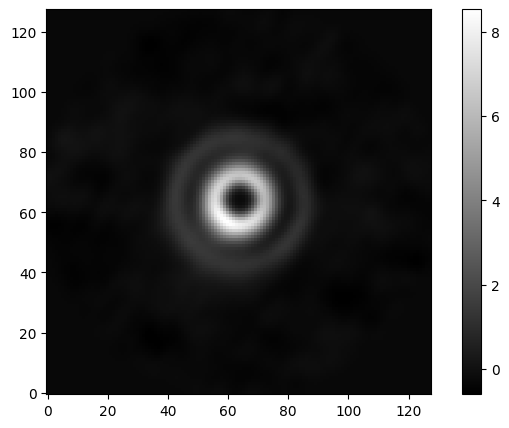

In [2]:
fit = fits.open("../../fits/mwc480_rescaled.fits")
fit.info()
img = fit[0].data
print(img.shape)
img2d = np.squeeze(img)
print(img2d.shape)
plt.figure(figsize=(8, 5))
plt.imshow(img2d, origin='lower', cmap='gray')
plt.colorbar()
plt.show()
fit.close()

In [3]:
img = img2d
ny, nx = img.shape

# Griglia cartesiana
x = np.linspace(-3, 3, nx)
y = np.linspace(-3, 3, ny)
xx, yy = np.meshgrid(x, y)

# Griglia polare
r_i = np.linspace(0.1, 3, 300)
theta_i = np.linspace(-np.pi, np.pi, 360)
rr, tt = np.meshgrid(r_i, theta_i)

# Converti griglia polare in x, y
xi = rr * np.cos(tt)
yi = rr * np.sin(tt)

# Prendo i valori dell'immagine
points = np.vstack((xx.flatten(), yy.flatten())).T
values = img.flatten()

# Interpoloazione dell'immagin su una griglia polare
grid_intensity = griddata(points, values, (xi, yi), fill_value=0)

# Per il profilo radiale, prendo la media lungo θ
real_profile = np.mean(grid_intensity, axis=0)
real_error = np.std(grid_intensity, axis=0)
real_error[real_error < 1e-8] = 1e-8

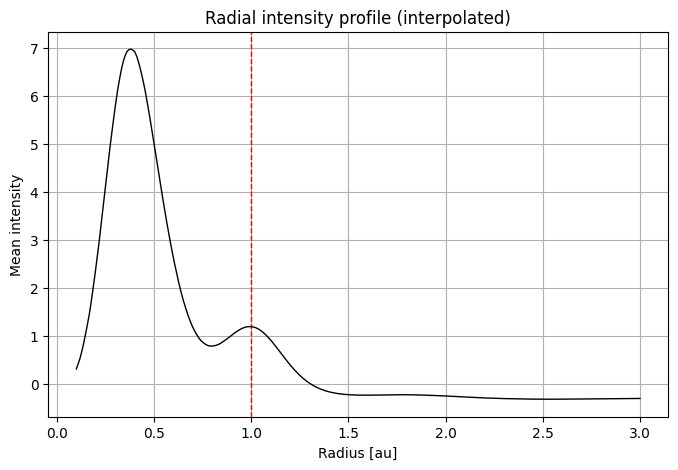

In [4]:
# Plot
plt.figure(figsize=(8, 5))
plt.axvline(1.0,
            color='red',
            linestyle='--',
            linewidth=1)
plt.plot(
    r_i,
    real_profile,
    color="black",
    linewidth=1,
)
plt.xlabel("Radius [au]")
plt.ylabel("Mean intensity")
plt.title("Radial intensity profile (interpolated)")
plt.grid(True)
plt.show()

### Synthetic Profile and Emcee setup

In [5]:
# --- Mask configuration for emcee ---
# Only fit data within this x-range (same units as r)
XMIN = 0.6
XMAX = 1.4

In [6]:
# Emcee
r = np.linspace(0.1, 3, 300)


def model(r, I0, gamma, r_g, sigma, f):
    c = 0.3
    R_cutL = 0.1  # Fixed
    R_cutR = 3.0  # Fixed

    r_sinc = c * (np.pi * ((r - r_g) / sigma))**2

    powerlaw = I0 * ((r / r_g)**(-gamma))
    sinc = np.sin(r_sinc) / r_sinc
    gauss = np.exp((-(r - r_g)**4) / (2 * sigma**4))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)
    # NO_SINC_MODEL
    gap_factor = (1 - f * (gauss))

    return powerlaw * gap_factor * L_cut_factor * R_cut_factor


def log_prior(parameters):
    I0, gamma, r_g, sigma, f = parameters
    if 0.5 < I0 < 5 and 0.1 < gamma < 2.5 and 0.5 < r_g < 1.0 and 0.01 < sigma < 0.8 and 0.1 < f < 1.0:
        return 0.0
    return -np.inf


def log_likelihood(parameters, r, data, error):
    model_profile = model(r, *parameters)
    return - 0.5 * np.sum(((data - model_profile) / error)**2)


def log_probability(parameters, r, data, error):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(parameters, r, data, error)


def make_mask_range(x, xmin=None, xmax=None):
    m = np.isfinite(x)
    if xmin is not None: m &= (x >= xmin)
    if xmax is not None: m &= (x <= xmax)
    return m


def log_probability_masked(theta, r, data, error, xmin, xmax):
    mask = make_mask_range(r, xmin, xmax)
    # safety: ignore bad points / zero or negative errors
    mask &= np.isfinite(data) & np.isfinite(error) & (error > 0)
    if not np.any(mask):
        return -np.inf
    return log_probability(theta, r[mask], data[mask], error[mask])


def compute_fit_score(r, data, error, theta_best):
    I_model = model(r, *theta_best)
    residuals = (data - I_model) / error
    chi2_red = np.mean(residuals**2)
    score = 1 / (1 + chi2_red)
    return score


# Setup for emcee
initial = np.array([1.0, 1.0, 1.0, 0.1, 0.5])
ndim = len(initial)
nwalkers = 20
initial_position = initial + 1e-3 * np.random.randn(nwalkers, ndim)

# Dati per emcee
# Qua va l'rms (scarto quadratico medio)
static_error = 0.1

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_masked, args=(r, real_profile, real_error, XMIN, XMAX))
sampler.run_mcmc(initial_position, 10000, progress=True)
flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)

theta_best = np.median(sampler.get_chain(discard=1000, flat=True), axis=0)

# Calcolo dello score
score = compute_fit_score(r, real_profile, real_error, theta_best)

# Best parameters and model
best_params = np.median(flat_samples, axis=0)
best_model = model(r_i, *best_params)


  0%|          | 0/10000 [00:00<?, ?it/s]d:\UNI\AAAThesis\DiskGen\.venv\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:13<00:00, 734.62it/s]


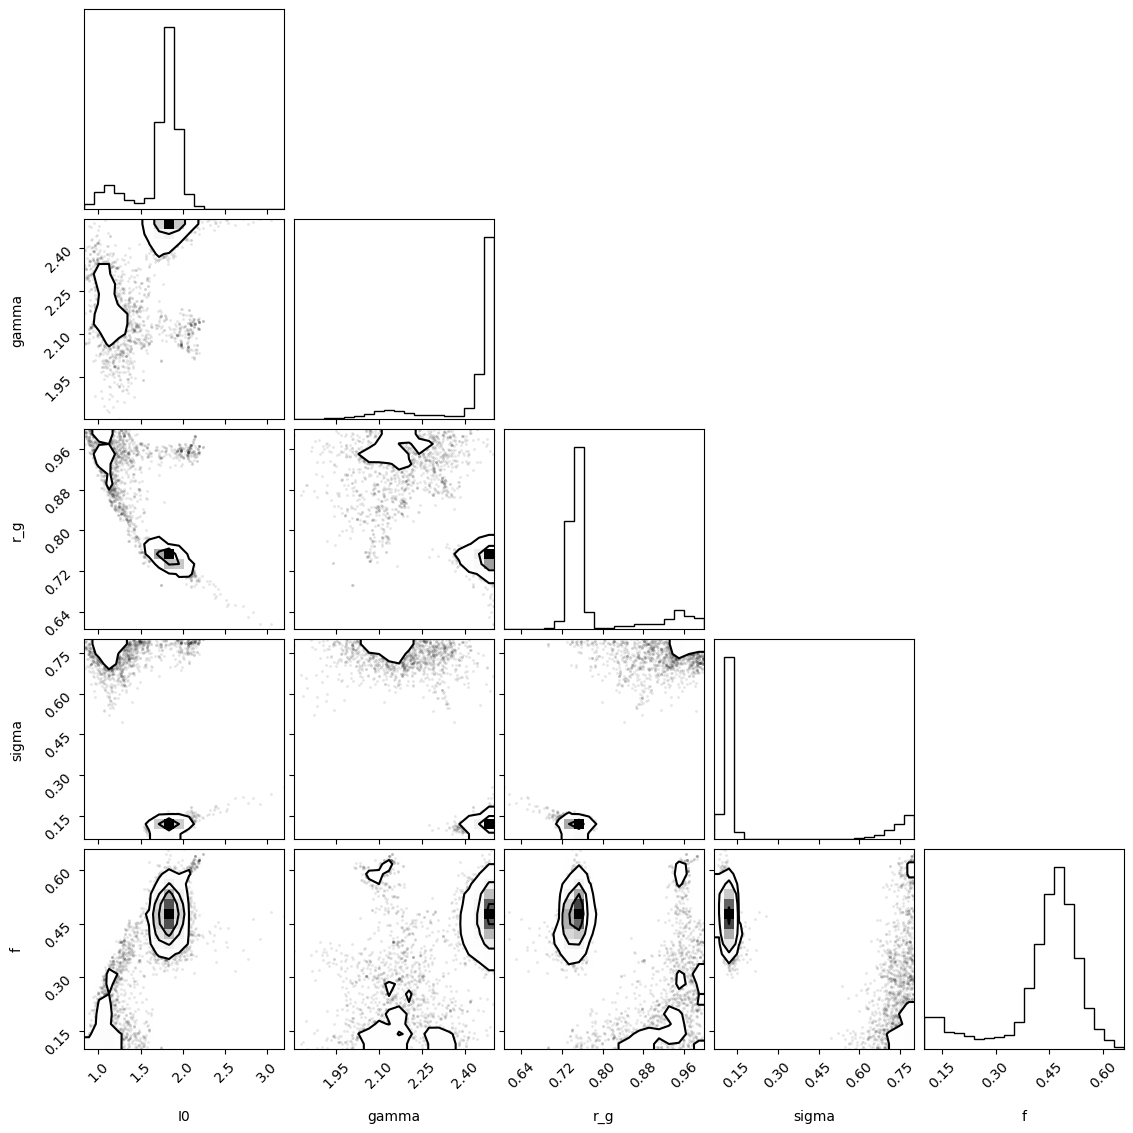

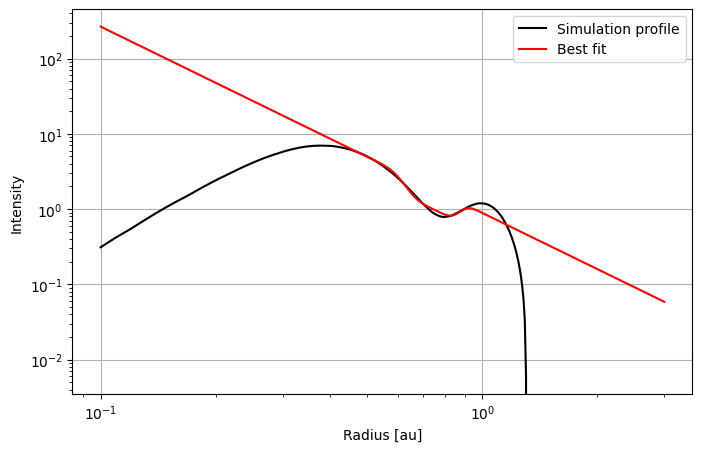

Fit score: 0.000
Best parameters:
I0: 1.8136
gamma: 2.4755
r_g: 0.7501
sigma: 0.1200
f: 0.4619


In [ ]:
# Corner plot
corner.corner(flat_samples, labels=["I0", "gamma", "r_g", "sigma", "f"], truths=[None] * 5)
plt.show()

# Comparison plot
plt.figure(figsize=(8, 5))
plt.plot(r_i, real_profile, label="Real profile", color="black")
plt.plot(r_i, best_model, label="Best fit", color="red")
plt.xlabel("Radius [au]")
plt.ylabel("Intensity")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.show()

# Score calculation
score = compute_fit_score(r, real_profile, real_error, theta_best)
print(f"Fit score: {score:.3f}")
print("Best parameters:")
for label, value in zip(["I0", "gamma", "r_g", "sigma", "f"], best_params):
    print(f"{label}: {value:.4f}")

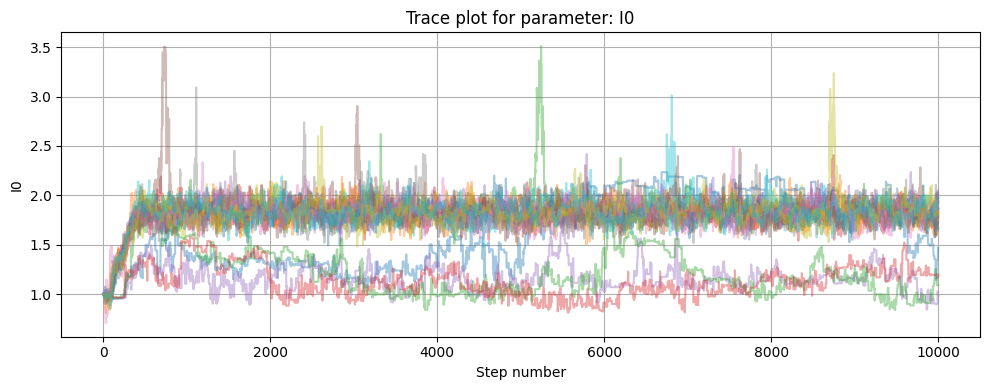

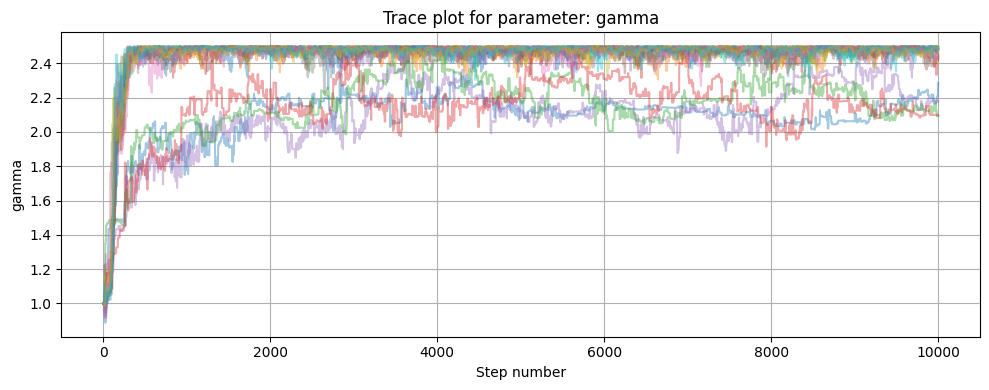

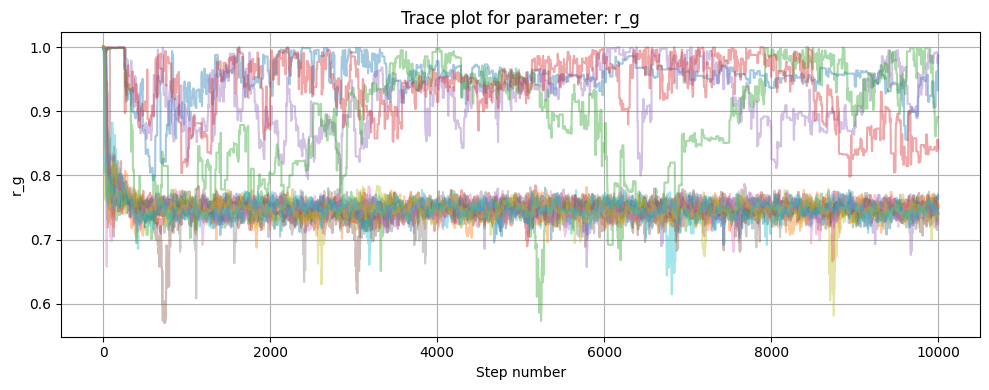

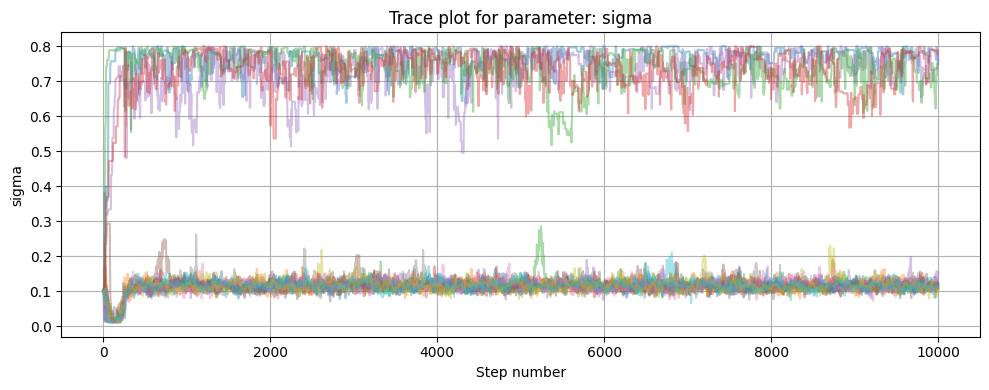

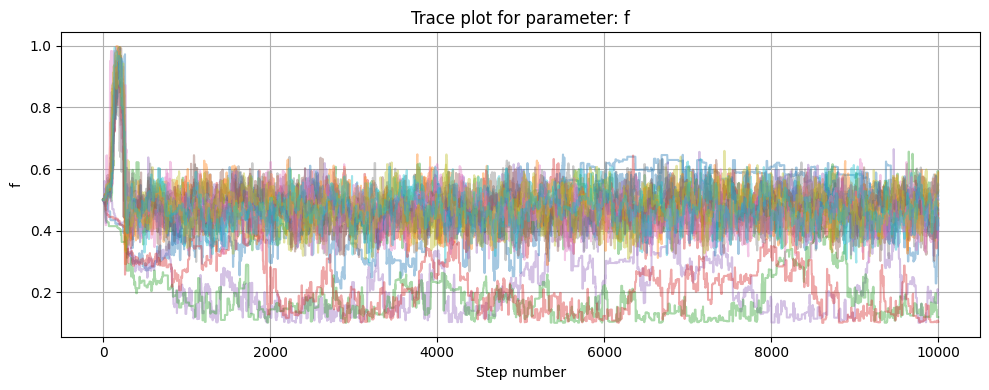

In [8]:
samples = sampler.get_chain()  # shape: (nsteps, nwalkers, ndim)
nsteps, nwalkers, ndim = samples.shape

labels = ["I0", "gamma", "r_g", "sigma", "f"]  # adjust if needed

for i in range(ndim):
    plt.figure(figsize=(10, 4))
    for w in range(nwalkers):
        plt.plot(samples[:, w, i], alpha=0.4)
    plt.title(f"Trace plot for parameter: {labels[i]}")
    plt.xlabel("Step number")
    plt.ylabel(labels[i])
    plt.grid(True)
    plt.tight_layout()
    plt.show()
